In [1]:
import yfinance as yf
import numpy as np
import datetime
from tqdm import tqdm

### get stock data
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import StockHistoricalDataClient
import my_secrets
import pytz
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO

import torch as th
th.autograd.set_detect_anomaly(True)
np.seterr(all='raise')

# from stable_baselines3.common.envs import DummyVecEnv
import gymnasium as gym

from sentence_transformers import SentenceTransformer

# Define the ticker symbol
stock_list = ["AAPL"]

In [2]:
date_start = datetime.datetime.strptime('2018-01-01-00:00:00','%Y-%m-%d-%H:%M:%S')
date_end = datetime.datetime.strptime('2023-03-15-00:00:00','%Y-%m-%d-%H:%M:%S')


In [145]:
for stock_code in tqdm(stock_list + ['QQQ']):
    import os
    if os.path.exists(f'./historical_price_data/{stock_code}.csv'):
        continue
    request_params = StockBarsRequest(
        symbol_or_symbols=stock_code,
        timeframe=TimeFrame.Day,
        start=date_start,
        end=date_end, 
        adjustment='all'
    )

    client = StockHistoricalDataClient(api_key=my_secrets.API_KEY, secret_key=my_secrets.SECRET_KEY) ### request stock price
    bars = client.get_stock_bars(request_params)
    bas_df = bars.df.droplevel(axis=0,level=0)
    bas_df.index = [i.replace(tzinfo=None).tz_localize(pytz.timezone('UTC')).tz_convert('US/Eastern') for i in bas_df.index]
    bas_df.to_csv(f'./{stock_code}.csv',index=True)



100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


## Load Stock

In [179]:
bas_df = pd.read_csv('./AAPL.csv',index_col=0)
QQQ = pd.read_csv('./QQQ.csv',index_col=0)

# Remove missing values from the data
bas_df['market_return'] = QQQ['close'].diff()
bas_df['stock_return'] = bas_df['close'].diff()
bas_df = bas_df.dropna()
bas_df

,open,high,low,close,volume,trade_count,vwap,market_return,stock_return
2018-01-03 00:00:00-05:00,40.68,41.15,40.54,40.61,127040432.0,188340.0,40.80,1.47,0.00
2018-01-04 00:00:00-05:00,40.68,40.90,40.57,40.80,97561040.0,153154.0,40.79,0.27,0.19
2018-01-05 00:00:00-05:00,40.89,41.35,40.80,41.26,104959444.0,152077.0,41.19,1.53,0.46
2018-01-08 00:00:00-05:00,41.11,41.40,41.01,41.11,90917476.0,138848.0,41.17,0.61,-0.15
2018-01-09 00:00:00-05:00,41.15,41.27,40.88,41.10,92079040.0,154009.0,41.10,0.01,-0.01
...,...,...,...,...,...,...,...,...,...
2023-03-08 00:00:00-05:00,151.79,152.45,150.82,151.85,51205963.0,405205.0,151.69,1.47,1.26
2023-03-09 00:00:00-05:00,152.54,153.50,149.22,149.59,59821351.0,480912.0,151.29,-5.12,-2.26
2023-03-10 00:00:00-05:00,149.21,149.93,146.63,147.51,75469048.0,609814.0,148.03,-4.08,-2.08
2023-03-13 00:00:00-04:00,146.82,152.12,146.72,149.47,90585023.0,760662.0,150.11,2.12,1.96


In [180]:
bas_df = bas_df.reset_index(drop=False)
bas_df['index'] = pd.to_datetime(bas_df['index'], utc=True)

In [181]:
bas_df['index'] = bas_df['index'].dt.date

## Read news

In [182]:
news = pd.read_csv('./AAPL_news.csv')
news['created_at'] = pd.to_datetime(news['created_at'])
news['created_at'] = news['created_at'].dt.date
news


,author,content,created_at,headline
0,Benzinga,<ul>\r\n\t<li>\r\n\t\t<i>Benzinga has featured...,2018-01-01,"Benzinga's Bulls & Bears: Apple, GE, Starbucks..."
1,Benzinga,"<p>In case you missed it, here are some of Ben...",2018-01-02,ICYMI: It's A New Year And Everyone's Polishin...
2,Benzinga,<p>Drexel Hamilton has named&nbsp;<strong>Appl...,2018-01-02,Here's Why Apple Is Drexel's Top IT Pick For 2018
3,Benzinga,"<p>Now that 2018 is finally here, everyone on ...",2018-01-02,"New Year Predictions: Bitcoin Drops, Ripple Ri..."
4,Benzinga,"<p>January is here and for stocks, that may no...",2018-01-02,The Best Sector ETFs For January: Familiar Lea...
...,...,...,...,...
8555,Anusuya Lahiri,<ul>\r\n\t<li><strong>Apple Inc</strong>&nbsp;...,2023-03-15,"Apple Joins Cost Cut Bandwagon, Eases On Bonus..."
8556,Shanthi Rexaline,"<p>Amid the fluid market condition, former hed...",2023-03-15,"A Retail Stock That Left Apple, Amazon, Tesla ..."
8557,Shanthi Rexaline,<p><strong>Apple&nbsp;Inc. </strong>(NASDAQ:<a...,2023-03-15,Apple Supplier Foxconn Guides To Flat Q1 After...
8558,Ananya Gairola,<p>Customers in the U.S. looking for more pers...,2023-03-15,Apple Unveils New Way To Buy iPhones In US: Ge...


In [280]:
# bas_df.reset_index(drop=False).merge(news, left='index', right='created_at')

data = pd.merge(
    bas_df, news, left_on='index', right_on='created_at'
)



## Sentence enbedding


In [281]:
model = SentenceTransformer('flax-sentence-embeddings/all_datasets_v4_MiniLM-L6')


In [282]:
data['headline_plus_content'] = data.apply(lambda x:x['headline'] + '\n'+ x['content'], axis=1)


In [283]:
encoded = model.encode(data['headline_plus_content'])


In [284]:
data[[f'vec_{vec}' for vec in range(encoded.shape[1])]] = encoded


/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/1414783857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[[f'vec_{vec}' for vec in range(encoded.shape[1])]] = encoded
/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/1414783857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[[f'vec_{vec}' for vec in range(encoded.shape[1])]] = encoded
/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/1414783857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [285]:
news_count = data.groupby('index')['content'].count()
data = data[['index'] + ['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'stock_return','market_return'] + [f'vec_{vec}' for vec in range(384)]].groupby(['index']).mean()
data['news_count'] = news_count.values
data = data.reset_index(drop=False)


/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/2422524649.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['news_count'] = news_count.values


## Feature engineering

In [286]:
class stock_index_calculator:
    def __init__(self) -> None:
        self.scaler_dict = {}

    # def fit(self, high_prices, low_prices, close_prices, stock_returns, market_returns):
    #     market_returns = market_returns

    #     metric_dict = {
    #         'votality':self.volatility(close_prices),
    #         'maximum_drawdown':self.maximum_drawdown(close_prices),
    #         'beta':self.beta(stock_returns, market_returns),
    #         'alpha':self.alpha(stock_returns, market_returns),
    #         'sharpe_ratio':self.sharpe_ratio(stock_returns),
    #         'sortino_ratio':self.sortino_ratio(stock_returns),
    #         'RSI':self.RSI(close_prices, window=14),
    #         'ATR':self.ATR(high_prices, low_prices, close_prices, window=14)
    #     }

    #     from sklearn.preprocessing import MinMaxScaler
    #     for key in metric_dict:
    #         scaler = MinMaxScaler((0.1,1)).fit(metric_dict[key].reshape(-1,1))
    #         self.scaler_dict[key] = scaler
        
    #     return self

    def transform(self, high_prices, low_prices, close_prices, stock_returns, market_returns):
        market_returns = market_returns

        metric_dict = {
            'votality':self.volatility(close_prices),
            'maximum_drawdown':self.maximum_drawdown(close_prices),
            'beta':self.beta(stock_returns, market_returns),
            'alpha':self.alpha(stock_returns, market_returns),
            'sharpe_ratio':self.sharpe_ratio(stock_returns),
            'sortino_ratio':self.sortino_ratio(stock_returns),
            'RSI':self.RSI(close_prices, window=14),
            'ATR':self.ATR(high_prices, low_prices, close_prices, window=14),
            **{f'closeprice_{i}':close_prices[-i] for i in range(100)}
        }

        # for key in metric_dict:
        #     scaler = self.scaler_dict[key]
        #     metric_dict[key] = scaler.transform(metric_dict[key].reshape(-1,1))
            
        return metric_dict
    
    # def fit_transform(self, high_prices, low_prices, close_prices, market_returns):
    #     self.fit(high_prices, low_prices, close_prices, market_returns)
    #     return self.transform(high_prices, low_prices, close_prices, market_returns)

    def volatility(self, close_prices):
        daily_returns = np.diff(close_prices) / close_prices[:-1]
        return np.std(daily_returns)

    def maximum_drawdown(self, close_prices):
        peak = close_prices[0]
        max_dd = 0
        for price in close_prices:
            if price > peak:
                peak = price
            dd = (peak - price) / peak
            if dd > max_dd:
                max_dd = dd
        return max_dd * 100

    def beta(self, stock_returns, market_returns):
        cov = np.cov(stock_returns, market_returns)
        return cov[0, 1] / np.var(market_returns)

    def alpha(self, stock_returns, market_returns):
        risk_free_rate = 0.02  # Example risk-free rate
        stock_beta = self.beta(stock_returns, market_returns)
        stock_mean_return = np.mean(stock_returns)
        market_mean_return = np.mean(market_returns)
        return stock_mean_return - (risk_free_rate + stock_beta * (market_mean_return - risk_free_rate))

    def sharpe_ratio(self, stock_returns):
        risk_free_rate = 0.02  # Example risk-free rate
        return (np.mean(stock_returns) - risk_free_rate) / np.std(stock_returns)

    def sortino_ratio(self, stock_returns):
        risk_free_rate = 0.02  # Example risk-free rate
        downside_returns = [ret for ret in stock_returns if ret < risk_free_rate]
        downside_deviation = np.std(downside_returns)
        return (np.mean(stock_returns) - risk_free_rate) / downside_deviation

    def RSI(self, close_prices, window=14):

        try:
            delta = np.diff(close_prices)
            up = delta.copy()
            down = delta.copy()
            up[up < 0] = 0
            down[down > 0] = 0
            avg_gain = np.mean(up[-window:])
            avg_loss = np.mean(np.abs(down[-window:]))
            RS = avg_gain / avg_loss
            return 100 - (100 / (1 + RS))
        
        except:
            return 0

    def ATR(self, high_prices, low_prices, close_prices, window=14):
        trs = np.maximum(high_prices[:-1], close_prices[1:]) - np.minimum(low_prices[:-1], close_prices[1:])
        atr = np.mean(trs[-window:])
        return atr
    




In [287]:
data = data.dropna(subset=['market_return','stock_return'])

In [288]:
summarize_windowsize=100
metrics_dict = {}

for end in range(0, data.shape[0]):
    if end<summarize_windowsize:
        metrics_dict[end] = {}
        continue
    
    start = end - summarize_windowsize
    sub_data = data.iloc[start:end,:]
    metircs = stock_index_calculator().transform(sub_data['high'].values, 
                                                 sub_data['low'].values, 
                                                 sub_data['close'].values, 
                                                 sub_data['stock_return'].values, 
                                                 sub_data['market_return'].values)
    metrics_dict[end] = metircs

metrics_dict = pd.DataFrame(metrics_dict).T


In [289]:
data[list(metrics_dict.columns)] = metrics_dict.values


/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/3634173283.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[list(metrics_dict.columns)] = metrics_dict.values
/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/3634173283.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[list(metrics_dict.columns)] = metrics_dict.values
/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/3634173283.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [290]:
data = data.dropna()


## Get Train Test

In [291]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]


## PCA

In [292]:
from sklearn.decomposition import PCA
n_pca = 100
pca = PCA(n_components=n_pca).fit(train_data[[f'vec_{vec}' for vec in range(encoded.shape[1])]].values.astype('float64'))
train_data[[f'pc_{pc}' for pc in range(n_pca)]] = pca.transform(train_data[[f'vec_{vec}' for vec in range(encoded.shape[1])]].values.astype('float64')).astype('float32')
test_data[[f'pc_{pc}' for pc in range(n_pca)]] = pca.transform(test_data[[f'vec_{vec}' for vec in range(encoded.shape[1])]].values.astype('float64')).astype('float32')



/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/176688289.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[[f'pc_{pc}' for pc in range(n_pca)]] = pca.transform(train_data[[f'vec_{vec}' for vec in range(encoded.shape[1])]].values.astype('float64')).astype('float32')
/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/ipykernel_63382/176688289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[[f'pc_{pc}' for pc in range(n_pca)]] = pca.transform(train_data[[f'vec_{vec}' for vec in

In [293]:
train_data  = train_data[['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'stock_return','market_return'] + [f'pc_{pc}' for pc in range(n_pca)] + ['news_count'] + list(metrics_dict.columns)]
test_data  = test_data[['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'stock_return','market_return'] + [f'pc_{pc}' for pc in range(n_pca)] + ['news_count'] + list(metrics_dict.columns)]


In [294]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
for var_ in ['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'stock_return','market_return'] + [f'pc_{pc}' for pc in range(n_pca)] + ['news_count'] + list(metrics_dict.columns):
    scaler = MinMaxScaler(feature_range=(0.1, 1))
    scaler = scaler.fit(train_data[[var_]].values)
    train_data[var_] = scaler.transform(train_data[[var_]].values).astype('float32')
    test_data[var_] = scaler.transform(test_data[[var_]].values).astype('float32')

train_data



,open,high,low,close,volume,trade_count,vwap,stock_return,market_return,pc_0,...,closeprice_90,closeprice_91,closeprice_92,closeprice_93,closeprice_94,closeprice_95,closeprice_96,closeprice_97,closeprice_98,closeprice_99
100,0.169644,0.167842,0.171167,0.169859,0.194161,0.117392,0.169422,0.520339,0.644577,0.605494,...,0.153733,0.156176,0.157432,0.157223,0.153788,0.155292,0.150565,0.150847,0.151078,0.152353
101,0.168347,0.165863,0.170789,0.169983,0.191434,0.119043,0.168551,0.536864,0.686205,0.328720,...,0.153803,0.153733,0.156176,0.157432,0.158730,0.153788,0.155292,0.150775,0.151006,0.151267
102,0.166122,0.163822,0.167886,0.167136,0.658700,0.139930,0.165873,0.516525,0.630457,0.412013,...,0.149197,0.153803,0.153733,0.156176,0.158945,0.158730,0.153788,0.155522,0.150934,0.151195
103,0.158954,0.158194,0.160631,0.162496,0.282344,0.146777,0.160332,0.505508,0.633135,0.233643,...,0.144033,0.149197,0.153803,0.153733,0.157656,0.158945,0.158730,0.154012,0.155695,0.151122
104,0.160684,0.159493,0.164101,0.163671,0.181477,0.119689,0.162075,0.544068,0.674033,0.450796,...,0.144731,0.144033,0.149197,0.153803,0.155149,0.157656,0.158945,0.158974,0.154180,0.155902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.931406,0.942919,0.943659,0.941093,0.158890,0.270546,0.942283,0.548729,0.664782,0.525610,...,0.965178,0.941591,0.976902,0.973273,0.993482,0.990188,0.971280,0.943831,0.928721,0.924620
1010,0.935176,0.933271,0.939621,0.928594,0.167044,0.265991,0.934251,0.450424,0.526265,0.601962,...,1.000000,0.965178,0.941591,0.976902,0.996276,0.993482,0.990188,0.974900,0.946469,0.931789
1011,0.916452,0.916450,0.916593,0.902049,0.149869,0.285816,0.911027,0.354237,0.446659,0.546456,...,0.996371,1.000000,0.965178,0.941591,1.000000,0.996276,0.993482,0.993887,0.977635,0.949602
1012,0.912249,0.921583,0.923659,0.913744,0.168649,0.286207,0.919370,0.616102,0.610252,0.559965,...,0.989393,0.996371,1.000000,0.965178,0.963759,1.000000,0.996276,0.997195,0.996681,0.980883


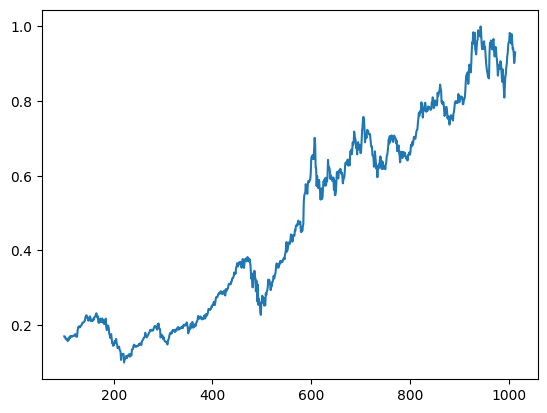

In [295]:
plt.plot(train_data['close'])

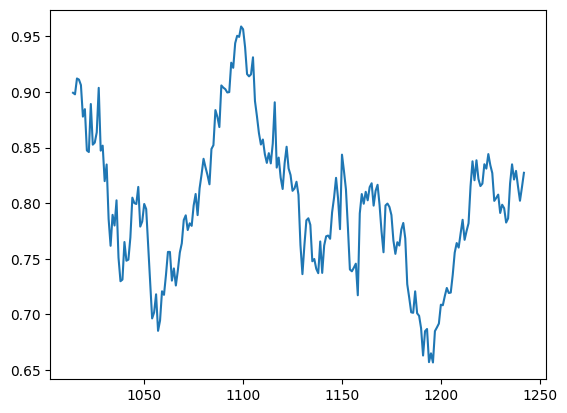

In [296]:
plt.plot(test_data['close'])

In [297]:


starting_money = 100000

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data, interval_size = 300):
        
        if interval_size is None:
            interval_size = len(data)
            
        start_date = int(np.random.uniform(low=0, high=data.shape[0]-interval_size))

        self.data = data.iloc[start_date: start_date+interval_size]
        # self.action_space = gym.spaces.Discrete(starting_money*2, start=-starting_money)
        self.action_space = gym.spaces.Box(low=-10,high=10,dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-10, high=10, shape=(len(data.columns),))
        self.max_net_worth = None
        self.net_worth_time_series = []
        self.starting_money = starting_money

    def reset(self, seed=42):
        # print(self.max_net_worth)
        self.current_step = 0
        self.account_balance = self.starting_money  # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance
        self.seed = seed
        self.history = []
        
        return self._next_observation(), {}

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step > len(self.data) - 1:
            self.current_step = 0
            terminated = True
        else:
            terminated = False
        truncated = False

        self.net_worth_time_series.append(self._get_reward())
        return self._next_observation(), self._get_reward(), terminated, truncated, {}

    def _take_action(self, action):
        
        action = action[0] * self.starting_money

        price = float(self.data.iloc[self.current_step].values[0])

        if action > 0:  # Buy
            shares_to_buy = int(min(self.account_balance, action) / price) - 1
            self.shares_held += shares_to_buy
            self.account_balance -= shares_to_buy * price
        elif action < 0:  # Sell

            shares_to_sell = min(self.shares_held, int(action/price))
            self.account_balance += shares_to_sell * price
            self.shares_held -= shares_to_sell

        self.net_worth = self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0]

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        # self.history.append(self.net_worth)

    def _get_reward(self):
        # print(self.net_worth, self.account_balance)
        return self.net_worth

# Create the trading environment




In [298]:


env = TradingEnvironment(train_data)
# envs_wrapper = gym.wrappers.RecordEpisodeStatistics(env, deque_size=10)
check_env(env)


/Users/chenyangkang/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [299]:
# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | 5.39e+07 |
| time/              |          |
|    fps             | 2512     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 300       |
|    ep_rew_mean          | 5.42e+07  |
| time/                   |           |
|    fps                  | 1098      |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.42     |
|    e

In [300]:
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data, interval_size=None)
    obs, _ = env.reset()

    for i in range(len(data)):
        # print(obs)
        action, _ = model.predict(obs)
        obs, _, _, _, _ = env.step(action)

    return env.net_worth_time_series


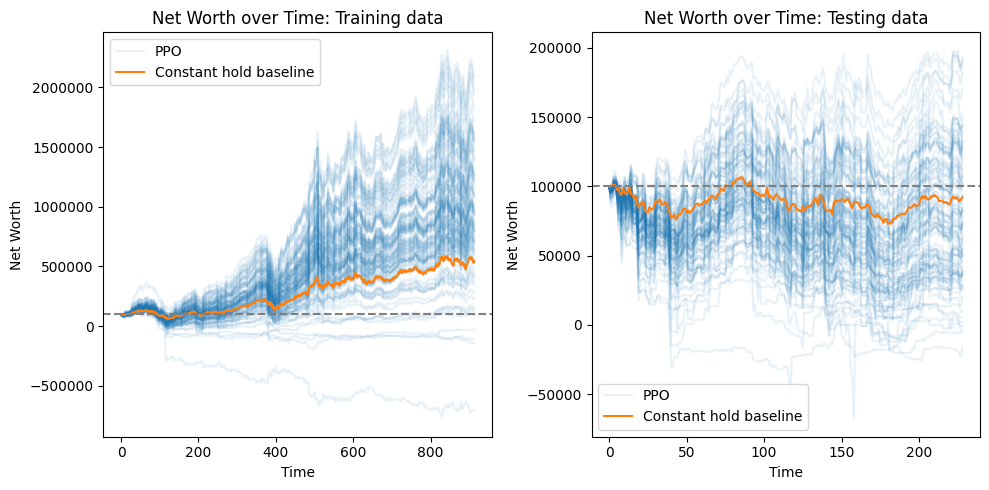

In [301]:
# Simulate the trading strategy on the testing data
import matplotlib.pyplot as plt


fig,ax = plt.subplots(1,2, figsize=(10,5))

# Train
for simulation in range(100):
    if simulation==0:
        ax[0].plot(simulate_trading_strategy(model, train_data), label='PPO', alpha=0.1, c='tab:blue')
    else:
        ax[0].plot(simulate_trading_strategy(model, train_data), alpha=0.1, c='tab:blue')
        
ax[0].plot((train_data['close'].values / train_data['close'].values[0]) * starting_money, label='Constant hold baseline', c='tab:orange')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Net Worth")
ax[0].ticklabel_format(style='plain')
ax[0].set_title("Net Worth over Time: Training data")
ax[0].axhline(starting_money, linestyle='dashed',c='grey')
ax[0].legend()

# Test
for simulation in range(100):
    if simulation==0:
        ax[1].plot(simulate_trading_strategy(model, test_data), label='PPO', alpha=0.1, c='tab:blue')
    else:
        ax[1].plot(simulate_trading_strategy(model, test_data), alpha=0.1, c='tab:blue')

ax[1].plot((test_data['close'].values / test_data['close'].values[0]) * starting_money, label='Constant hold baseline', c='tab:orange')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Net Worth")
ax[1].ticklabel_format(style='plain')
ax[1].set_title("Net Worth over Time: Testing data")
ax[1].axhline(starting_money, linestyle='dashed',c='grey')
ax[1].legend()

plt.tight_layout()
plt.show()

